In [ ]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import boutdata
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *



%load_ext autoreload
%autoreload 2

# 1D example case verification

In [1]:
#!/usr/bin/env python3

# Python script to run and analyse MMS test

from __future__ import division
from __future__ import print_function

try:
  from builtins import str
except:
  pass

from boututils.run_wrapper import shell, launch, getmpirun
from boutdata.collect import collect

from numpy import sqrt, max, abs, mean, array, log, concatenate
import os

In [2]:
case_path = r"/ssd_scratch/hcases/integrated-tests/1D-recycling"
hermes_path = r"/ssd_scratch/hermes-3/build-mc-fast-recycling/hermes-3"

datapath = os.path.join(case_path,"BOUT.dmp.0.nc")
# shell(f"rm {datapath}")

s, out = launch(f"{hermes_path} -d {case_path}", nproc=1, pipe=True)

getmpirun: using the default mpirun -np


In [3]:
launch?

Signature:
launch(
    command,
    runcmd=None,
    nproc=None,
    mthread=None,
    output=None,
    pipe=False,
    verbose=False,
)
Docstring:
Launch parallel MPI jobs

>>> status = launch(command, nproc, output=None)

Parameters
----------
command : str
    The command to run
runcmd : str, optional
    Command for running parallel job; defaults to what getmpirun() returns"
nproc : int, optional
    Number of processors (default: all available processors)
mthread : int, optional
    Number of omp threads (default: the value of the
    ``OMP_NUM_THREADS`` environment variable
output : str, optional
    Name of file to save output to
pipe : bool, optional
    If True, return the output of the command
verbose : bool, optional
    Print the full command to be run before running it

Returns
-------
tuple : (int, str)
    The return code, and either command output if pipe=True else None
File:      /ssd_scratch/anaconda3/lib/python3.9/site-packages/boututils/run_wrapper.py
Type:      fun

In [ ]:


shell("rm data/BOUT.dmp.0.nc")

# Link to the executable
shell("ln -s ../../../hermes-3 hermes-3")

success = True

path = "data"

s, out = launch("./hermes-3 -d " + path, nproc=1, pipe=True)

# Save output to log file
with open("run.log", "w") as f:
  f.write(out)

Pe = collect("Pe", tind=-1, path=path)
Ne = collect("Ne", tind=-1, path=path)
Tnorm = collect("Tnorm", path=path)
Te = Pe / Ne
Te_up = Te[-1,0,0,0] * Tnorm

# Upstream electron temperature should be about 60eV
if Te_up < 50 or Te_up > 70:
  success = False
  print("Electron temperature failed: {}eV. Expecting about 60eV".format(Te_up))

Ti = collect("Td+", tind=-1, path=path)
Ti_up = Ti[-1,0,0,0] * Tnorm
# Upstream ion temperature should be about 140eV
if Ti_up < 130 or Ti_up > 150:
  success = False
  print("Ion temperature failed: {}eV. Expecting about 140eV".format(Ti_up))

if success:
  print(" => Test passed")
  exit(0)
else:
  print(" => Test failed")
  exit(1)


In [ ]:
cases = {}
cases["before"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/1d_recycling_before", guard_replace = False).ds
cases["after"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/1d_recycling_after", guard_replace = False, squeeze = True).ds
# cases["sheathtest"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/fr1d_5_sheath_hbalance_test", guard_replace = False).ds

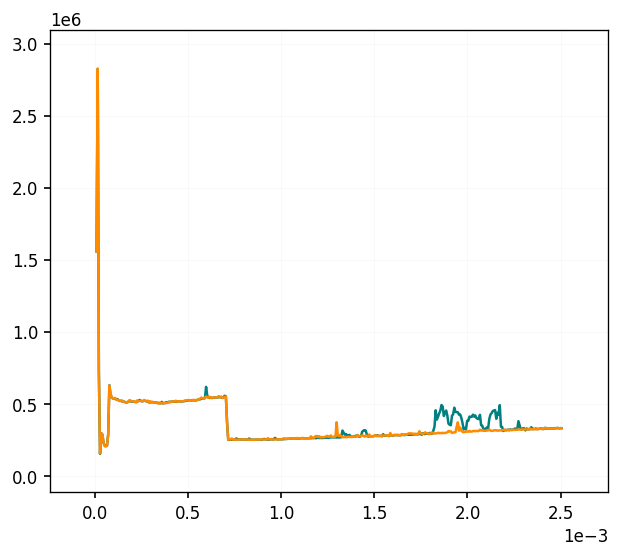

In [ ]:
fig, ax = plt.subplots()

for name in cases:
    ds = cases[name]
    wtime = ds["wtime"].values
    stime = np.diff(ds["t"].values, prepend = ds["t"].values[0]*0.99)
    wtime_per_stime = wtime/stime
    ax.plot(ds["t"].values, wtime_per_stime, label = name)

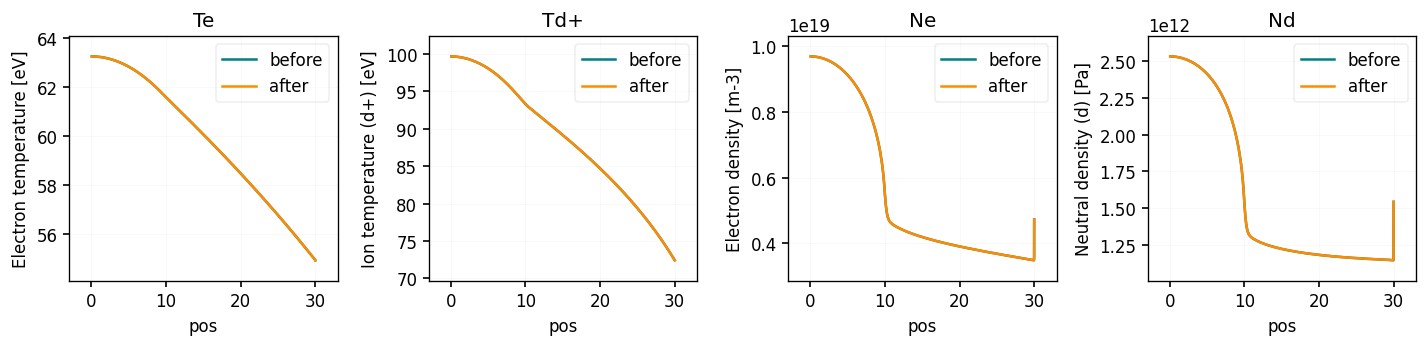

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(12,3), dpi = 120)

params = ["Te", "Td+", "Ne", "Nd"]

for name in cases:
    ds = cases[name].isel(t=-1, pos = slice(2,-2))
    
    for i, param in enumerate(params):
        ax = axes[i]
        ds[param].plot(ax = ax, label = name)
        ax.set_title(param)
        ax.legend()
    
fig.tight_layout()